# Zvi Badash 214553034
## Assignment 15
### Question 3 - Using transfer learning to classify images from the CIFAR10 dataset
The video explaining the exercise can be found [here](https://youtu.be/X_hfCh3eUTM)

## Imports

In [28]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

## Download the CIFAR10 dataset and visualize a few examples from each class

In [29]:
dataset = torchvision.datasets.CIFAR10(root='./data', download=True)

Files already downloaded and verified


In [30]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [31]:
imgs_per_class = 7

In [32]:
# Create a dictionary of class names and imgs_per_class corresponding indices
class_dict = {
    c: [i for i, label in enumerate(dataset.targets) if label == classes.index(c)][:imgs_per_class]
    for c in classes
}

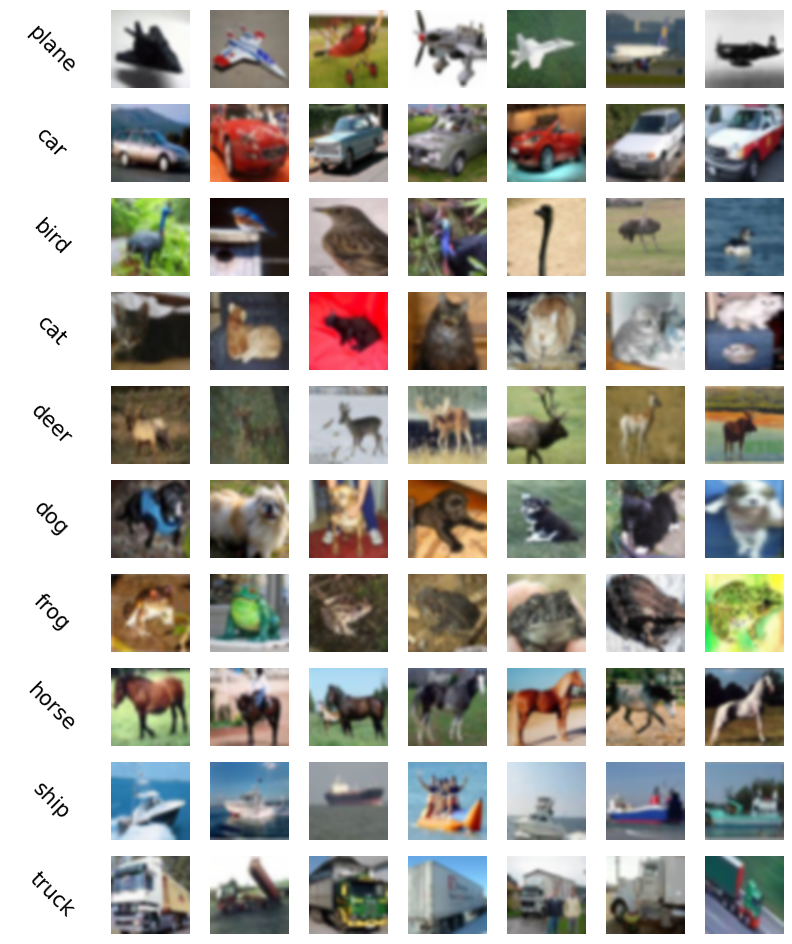

In [33]:
# Plot the images in a grid, where the first cell in each row is the class name
fig, axs = plt.subplots(len(classes), imgs_per_class + 1, figsize=(10, 12))
for i, c in enumerate(classes):
    # Plot the class name in the first cell of the row
    axs[i, 0].text(0.5, 0.5, c, horizontalalignment='center', verticalalignment='center', fontsize=15, rotation=-45)

    # Plot the images in the rest of the cells in the row
    for j, idx in enumerate(class_dict[c]):
        axs[i, j + 1].imshow(dataset[idx][0], interpolation='bicubic')

# Remove the axes
for ax in axs.flat:
    ax.set_axis_off()

## Load the CIFAR10 dataset into train/test dataloaders

In [34]:
batch_size = 128

In [35]:
# Define the transformation to be applied to each image, so that it will be in the same format as the images the ResNet18 model was trained on
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # Converts the image to a tensor
    torchvision.transforms.Resize(224, antialias=True), # Resizes the image to 224x224
    torchvision.transforms.Normalize(mean, std) # Normalize the image
])

In [36]:
# Define the inverse transformation, so that we can plot the images later without interference from the normalization
inverse_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize([-m / s for m, s in zip(mean, std)], [1 / s for s in std]), # Denormalize the image
    torchvision.transforms.Resize(32, antialias=True), # Resize the image back to 32x32
    torchvision.transforms.ToPILImage() # Convert the image to a PIL image
])

In [37]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Load the pretrained ResNet18 model

In [39]:
# Show the number of trainable parameters in the model (taken from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8)
def num_of_trainable_params(model):
    """
    Calculate the number of trainable parameters in the model
    :param model: The model.
    :return: The number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [40]:
# Load the pretrained ResNet18 model
resnet_model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
# Show the last layer of the model -- the classification head which we'll shortly replace with our own
list(resnet_model.named_children())[-1]

('fc', Linear(in_features=512, out_features=1000, bias=True))

In [42]:
# Replace the classification head with a new one that outputs 10 classes instead of 1000 (For CIFAR10 instead of ImageNet)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(classes))

In [43]:
num_of_trainable_params(resnet_model)

11181642

In [44]:
# Freeze all network parameters
for param in resnet_model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in resnet_model.fc.parameters():
    param.requires_grad = True

In [45]:
num_of_trainable_params(resnet_model)

5130

In [46]:
# Define the device to be used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [47]:
resnet_model = resnet_model.to(device)

## Train the partially trained model on the CIFAR10 dataset

In [48]:
loss_fn = nn.CrossEntropyLoss()

In [49]:
# I chose the learning rate after a few trials
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0003)

In [50]:
max_epochs = 15

In [51]:
def test_acc(test_model):
    """
    Calculate the accuracy of the model on the test set
    :return: The accuracy.
    """
    test_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = test_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

### The training loop

In [52]:
%%time
resnet_model.train()
for epoch in range(max_epochs):
    with tqdm(train_loader, unit="batch") as t_epoch:
        for idx, (inputs, labels) in enumerate(t_epoch):
            t_epoch.set_description(f"Epoch {epoch}")

            # Forward pass
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            t_epoch.set_postfix(Loss=loss.item())

    if test_acc(resnet_model) > 0.7: # Stop training if the model has reached the desired accuracy
        break

Epoch 0: 100%|██████████| 391/391 [00:33<00:00, 11.50batch/s, Loss=1.02]


CPU times: user 18.4 s, sys: 6.83 s, total: 25.3 s
Wall time: 41.2 s


In [53]:
print(f'Accuracy: {test_acc(resnet_model) * 100:.2f}%')

Accuracy: 74.74%


## Calculate the 10 worst classified images (the images that were incorrectly classified with the highest confidence)

In [54]:
imgs_per_row = 5
rows = 4

In [55]:
wrongly_classified = []

In [56]:
# For each image, calculate the confidence of the model in the predicted class
resnet_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Get the confidence of the model in the predicted class
        confidence = nn.functional.softmax(outputs, dim=1)[torch.arange(len(outputs)), predicted]

        # For each image, if the model was wrong, add the image, the actual label, the predicted class and the confidence to the list
        for i in range(len(inputs)):
            if predicted[i] != labels[i]:
                wrongly_classified.append((inputs[i], predicted[i], labels[i], confidence[i]))

In [57]:
# Sort the list by confidence
wrongly_classified.sort(key=lambda x: x[3], reverse=True)
wrongly_classified = wrongly_classified[:rows * imgs_per_row]

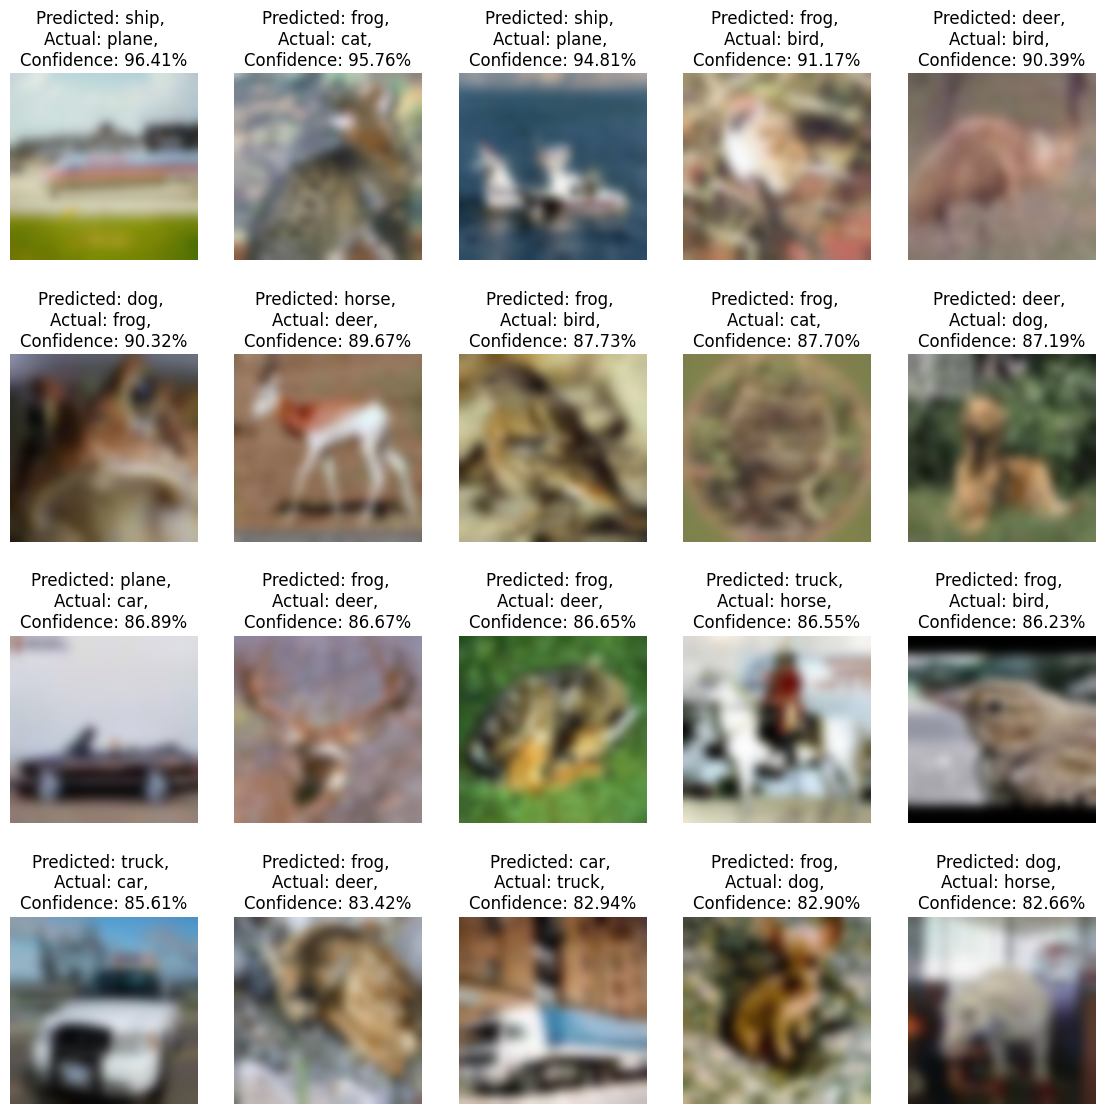

In [58]:
fig, axs = plt.subplots(len(wrongly_classified) // imgs_per_row, imgs_per_row, figsize=(14, 14))
for i, (img, predicted, label, confidence) in enumerate(wrongly_classified):
    img = inverse_transform(img.cpu())
    axs[i // imgs_per_row, i % imgs_per_row].imshow(img, interpolation='bicubic')
    axs[i // imgs_per_row, i % imgs_per_row].set_title(f"Predicted: {classes[predicted]}, \nActual: {classes[label]}, \nConfidence: {confidence * 100:.2f}%")
    axs[i // imgs_per_row, i % imgs_per_row].set_axis_off()

## Define a residual block and the new model

In [59]:
def layer_summary(model, X_shape):
    X = torch.randn(*X_shape)
    for layer in model.children():
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [60]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [61]:
my_res_model = nn.Sequential(
    Residual(128, use_1x1conv=True, strides=2),
    Residual(64, use_1x1conv=True, strides=2),
    Residual(64, use_1x1conv=True),
    nn.AdaptiveAvgPool2d((2, 2)), nn.Flatten(), nn.Dropout(0.4),
    nn.LazyLinear(64), nn.ReLU(), nn.Dropout(0.4),
    nn.LazyLinear(32), nn.ReLU(),
    nn.LazyLinear(len(classes))
)

In [62]:
layer_summary(my_res_model, (128, 3, 32, 32))

Residual output shape:	 torch.Size([128, 128, 16, 16])
Residual output shape:	 torch.Size([128, 64, 8, 8])
Residual output shape:	 torch.Size([128, 64, 8, 8])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 64, 2, 2])
Flatten output shape:	 torch.Size([128, 256])
Dropout output shape:	 torch.Size([128, 256])
Linear output shape:	 torch.Size([128, 64])
ReLU output shape:	 torch.Size([128, 64])
Dropout output shape:	 torch.Size([128, 64])
Linear output shape:	 torch.Size([128, 32])
ReLU output shape:	 torch.Size([128, 32])
Linear output shape:	 torch.Size([128, 10])


## Train the newly created model

In [63]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [64]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [65]:
batch_size = 32

In [66]:
max_epochs = 20

In [67]:
my_res_model = my_res_model.to(device)

In [68]:
optimizer = torch.optim.Adam(my_res_model.parameters(), lr=7e-5)

In [69]:
num_of_trainable_params(my_res_model)

368554

In [70]:
%%time
my_res_model.train()
for epoch in range(max_epochs):
    with tqdm(train_loader, unit="batch") as t_epoch:
        for idx, (inputs, labels) in enumerate(t_epoch):
            t_epoch.set_description(f"Epoch {epoch}")

            # Forward pass
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = my_res_model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            t_epoch.set_postfix(Loss=loss.item())

    if test_acc(my_res_model) > 0.7: # Stop training if the model has reached the desired accuracy
        break

Epoch 16: 100%|██████████| 391/391 [00:05<00:00, 75.48batch/s, Loss=0.668]


CPU times: user 1min 11s, sys: 10.6 s, total: 1min 21s
Wall time: 1min 48s


In [71]:
print(f'Accuracy: {test_acc(my_res_model) * 100:.2f}%')

Accuracy: 70.27%


In [72]:
torch.save(my_res_model.state_dict(), 'my_res_model.pt')

## Deciding which model is preferable

Throughout the assignment, we defined two models with a key difference -- the first model is based upon *another* proven-to-be successful model, the ResNet-18 which had undergo lots of optimization and was designed with a lot of thought. The second model is a model that was pretty much given to us, but I had lots of room to tweak it myself and it is trained from scratch. The second model is based on residual blocks that we defined here, with little attachments near the classification head.

The model I'd prefer (with high confidence) is the first model. Here are some reasons and evidence to support my claim:
- The first model reached 70% accuracy after a single epoch of training, while the second model took 16 (!) epochs to reach the same accuracy.
- The first model is practically already trained, and the weights from training on ImageNet's data apparently carries over to the CIFAR-10 dataset, while the second model is trained from scratch.
- To build the first model, I practically only had to define the classification head, a very easy task that took me way less time than defining the second model.
- To add to the first point, the first model has only ~5K trainable parameters, while the second model has ~370K trainable parameters. This means that the first model is much more efficient and faster to train. The training time of the first model is ~70% of the second model's training time.
- Also, the small number of trainable parameters in the first model also means that we have to be way less careful about memorizing the training data, and the model is less prone to overfitting.